We have used the "US Treasury Zero-Coupon Yield curve" for 30 years and "3-month T-bill yield". Data can be downloaded from FRED.

In [1]:
import pandas as pd
import glob
from functools import reduce
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

In [4]:
# Path to your CSV files
path = '/Users/hnyang/MF728project/*.csv'  # Adjust this to the path where your CSV files are stored
all_files = glob.glob(path)
all_files

['/Users/hnyang/MF728project/zero_coupon_yields_10.csv',
 '/Users/hnyang/MF728project/three_month_tbills.csv',
 '/Users/hnyang/MF728project/zero_coupon_yields_7.csv',
 '/Users/hnyang/MF728project/zero_coupon_yields_5.csv',
 '/Users/hnyang/MF728project/zero_coupon_yields_1.csv',
 '/Users/hnyang/MF728project/zero_coupon_yields_2.csv',
 '/Users/hnyang/MF728project/zero_coupon_yields_3.csv',
 '/Users/hnyang/MF728project/zero_coupon_yields_20.csv',
 '/Users/hnyang/MF728project/zero_coupon_yields_30.csv']

In [5]:
# List to hold data from each file
dataframes = []

# Read each CSV file and append to the list
for filename in all_files:
    df = pd.read_csv(filename)
    df['DATE'] = pd.to_datetime(df['DATE'], errors='coerce')
    dataframes.append(df)

# Merge all dataframes on the 'DATE' column
merged_df = reduce(lambda left, right: pd.merge(left, right, on='DATE', how='outer'), dataframes)

# Filter rows by date range
start_date = '1981-09-01'
end_date = '2024-04-15'
merged_df = merged_df[(merged_df['DATE'] >= start_date) & (merged_df['DATE'] <= end_date)]

In [6]:
merged_df.head()

,DATE,DGS10,DGS3MO,DGS7,DGS5,DGS1,DGS2,DGS3,DGS20,DGS30
5130,1981-09-01,15.41,17.01,15.71,16.12,17.060,16.780,16.57,15.09,14.70
5131,1981-09-02,15.40,16.65,15.75,16.09,17.160,16.780,16.43,15.11,14.70
5132,1981-09-03,15.48,16.96,15.78,16.14,17.310,16.900,16.48,15.21,14.82
5133,1981-09-04,15.51,16.64,15.86,16.17,17.240,16.890,16.52,15.24,14.84
5134,1981-09-07,.,.,.,.,.,.,.,.,.


In [7]:
# Make sure that 'DATE' is the DataFrame index for easier manipulation
merged_df.set_index('DATE', inplace=True)

# Convert all columns to numeric as they might be read as strings (especially if there are '.' from Excel)
merged_df = merged_df.apply(pd.to_numeric, errors='coerce')

# Now use interpolate with a time method, which will do a time-weighted interpolation
merged_df.interpolate(method='time', inplace=True)

merged_df.head()

,DGS10,DGS3MO,DGS7,DGS5,DGS1,DGS2,DGS3,DGS20,DGS30
DATE,,,,,,,,,
1981-09-01,15.41,17.010,15.710,16.120,17.0600,16.780,16.57,15.09,14.7000
1981-09-02,15.40,16.650,15.750,16.090,17.1600,16.780,16.43,15.11,14.7000
1981-09-03,15.48,16.960,15.780,16.140,17.3100,16.900,16.48,15.21,14.8200
1981-09-04,15.51,16.640,15.860,16.170,17.2400,16.890,16.52,15.24,14.8400
1981-09-07,15.57,16.565,15.905,16.215,17.2775,16.935,16.55,15.33,14.9525


In [23]:
#merged_df[['DGS3MO']].to_csv('D:/python/MF728project/DGS3MO.csv', header=True)
#merged_df.drop(columns=['DGS3MO']).to_csv('D:/python/MF728project/DGS1_7.csv', header=True)

In [8]:
merged_df.describe()

,DGS10,DGS3MO,DGS7,DGS5,DGS1,DGS2,DGS3,DGS20,DGS30
count,11120.000000,11120.000000,11120.000000,11120.000000,11120.000000,11120.000000,11120.000000,11120.000000,11120.000000
mean,5.422832,3.803417,5.235061,4.969471,4.136341,4.448086,4.639107,5.609749,5.849459
std,3.124419,3.194697,3.225921,3.305004,3.356785,3.433397,3.401959,2.824321,2.872706
min,0.520000,0.000000,0.360000,0.190000,0.040000,0.090000,0.100000,0.870000,0.990000
25%,2.870000,0.810000,2.550000,2.110000,1.120000,1.330000,1.557500,3.400000,3.570000
50%,4.760000,3.750000,4.690000,4.550000,4.110000,4.271250,4.410000,5.310000,5.240000
75%,7.290000,5.700000,7.080000,6.810000,6.070000,6.380000,6.550000,6.831349,7.580000
max,15.840000,17.010000,16.050000,16.270000,17.310000,16.950000,16.590000,15.780000,15.210000


In [9]:
merged_df.isnull().sum()

DGS10     0
DGS3MO    0
DGS7      0
DGS5      0
DGS1      0
DGS2      0
DGS3      0
DGS20     0
DGS30     0
dtype: int64

In [10]:
# Initialize a dictionary to hold the interpolated yield curves
interpolated_curves = {}

# Known maturities
known_maturities = np.array([1, 2, 3, 5, 7, 10, 20, 30])

# Interpolating for each date
for date, row in merged_df.iterrows():
    # Extract the yields for the known maturities
    known_yields = row[['DGS1', 'DGS2', 'DGS3', 'DGS5', 'DGS7', 'DGS10', 'DGS20', 'DGS30']].values
    # Setup cubic spline interpolation
    cs = CubicSpline(known_maturities, known_yields)
    # Maturities to interpolate
    full_range_maturities = np.arange(1, 31)
    # Interpolate yields for the full range
    interpolated_yields = cs(full_range_maturities)
    # Store the interpolated yields in the dictionary
    interpolated_curves[date] = interpolated_yields

# Convert the dictionary to a DataFrame
interpolated_df = pd.DataFrame(interpolated_curves).T
interpolated_df.columns = [f'DGS{m}' for m in full_range_maturities]  # Name the columns according to maturity

In [11]:
interpolated_df['DGS3MO'] = merged_df['DGS3MO']
interpolated_df.head()

,DGS1,DGS2,DGS3,DGS4,DGS5,DGS6,DGS7,DGS8,DGS9,DGS10,...,DGS22,DGS23,DGS24,DGS25,DGS26,DGS27,DGS28,DGS29,DGS30,DGS3MO
1981-09-01,17.0600,16.780,16.57,16.350396,16.120,15.898415,15.710,15.573295,15.478799,15.41,...,15.049236,15.025332,14.997763,14.965539,14.927672,14.883173,14.831054,14.770326,14.7000,17.010
1981-09-02,17.1600,16.780,16.43,16.225968,16.090,15.924878,15.750,15.604572,15.490415,15.40,...,15.093330,15.078842,15.057928,15.028848,14.989861,14.939224,14.875196,14.796035,14.7000,16.650
1981-09-03,17.3100,16.900,16.48,16.262789,16.140,15.967593,15.780,15.640102,15.546094,15.48,...,15.177243,15.156281,15.130776,15.099616,15.061687,15.015875,14.961065,14.896145,14.8200,16.960
1981-09-04,17.2400,16.890,16.52,16.302912,16.170,16.019604,15.860,15.720523,15.604793,15.51,...,15.232570,15.222048,15.204398,15.177676,15.139941,15.089248,15.023655,14.941220,14.8400,16.640
1981-09-07,17.2775,16.935,16.55,16.336354,16.215,16.066772,15.905,15.767511,15.657616,15.57,...,15.324179,15.314622,15.298188,15.273045,15.237358,15.189294,15.127019,15.048698,14.9525,16.565


In [29]:
# interpolated_df.drop(columns=['DGS3MO']).to_csv('D:/python/MF728project/DGS_30.csv', header=True)

In [12]:
cols = interpolated_df.columns.tolist() 
cols = [cols[-1]] + cols[:-1] 
interpolated_df = interpolated_df[cols]

In [13]:
interpolated_df.head()

,DGS3MO,DGS1,DGS2,DGS3,DGS4,DGS5,DGS6,DGS7,DGS8,DGS9,...,DGS21,DGS22,DGS23,DGS24,DGS25,DGS26,DGS27,DGS28,DGS29,DGS30
1981-09-01,17.010,17.0600,16.780,16.57,16.350396,16.120,15.898415,15.710,15.573295,15.478799,...,15.070462,15.049236,15.025332,14.997763,14.965539,14.927672,14.883173,14.831054,14.770326,14.7000
1981-09-02,16.650,17.1600,16.780,16.43,16.225968,16.090,15.924878,15.750,15.604572,15.490415,...,15.103136,15.093330,15.078842,15.057928,15.028848,14.989861,14.939224,14.875196,14.796035,14.7000
1981-09-03,16.960,17.3100,16.900,16.48,16.262789,16.140,15.967593,15.780,15.640102,15.546094,...,15.194779,15.177243,15.156281,15.130776,15.099616,15.061687,15.015875,14.961065,14.896145,14.8200
1981-09-04,16.640,17.2400,16.890,16.52,16.302912,16.170,16.019604,15.860,15.720523,15.604793,...,15.237907,15.232570,15.222048,15.204398,15.177676,15.139941,15.089248,15.023655,14.941220,14.8400
1981-09-07,16.565,17.2775,16.935,16.55,16.336354,16.215,16.066772,15.905,15.767511,15.657616,...,15.328694,15.324179,15.314622,15.298188,15.273045,15.237358,15.189294,15.127019,15.048698,14.9525


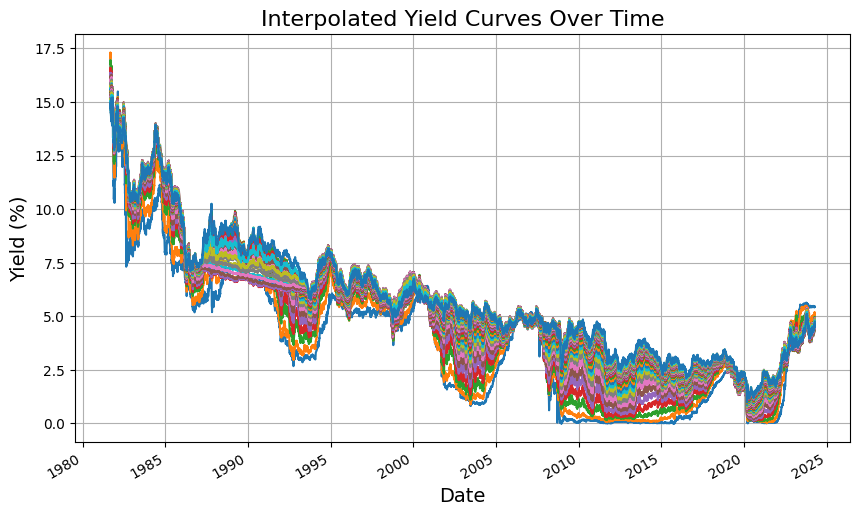

In [16]:
plt.figure(figsize=(10, 6))

for column in interpolated_df.columns:
    plt.plot(interpolated_df.index, interpolated_df[column], label=column)

plt.title('Interpolated Yield Curves Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Yield (%)', fontsize=14)

plt.gcf().autofmt_xdate()  

plt.grid(True) 
plt.show()

In [21]:
import numpy as np

class BasicCIRModel:
    """Cox-Ingersoll-Ross (CIR) model for interest rate dynamics."""
    
    def __init__(self, kappa: float, mu_r: float, sigma: float):
        """
        Initializes the CIR model with parameters.
        :param kappa: Mean reversion speed.
        :param mu_r: Long-term mean interest rate.
        :param sigma: Volatility of the interest rate.
        """
        self.kappa = kappa
        self.mu_r = mu_r
        self.sigma = sigma

    def next_rate(self, current_rate: float, dt: float) -> float:
        """
        Simulates the next interest rate using the Euler-Maruyama method.
        :param current_rate: Current interest rate.
        :param dt: Time increment.
        :return: Next interest rate.
        """
        normal_shock = np.random.normal(0, 1)
        drift = self.kappa * (self.mu_r - current_rate) * dt
        diffusion = self.sigma * np.sqrt(max(current_rate, 0)) * np.sqrt(dt) * normal_shock
        new_rate = current_rate + drift + diffusion
        return max(new_rate, 0)  # Ensure non-negativity

    def exact_solution(self, initial_rate: float, maturity: float) -> float:
        """
        Calculates the exact bond price under the CIR model for a zero-coupon bond.
        :param initial_rate: Initial interest rate.
        :param maturity: Time to maturity of the bond.
        :return: Bond price.
        """
        gamma = np.sqrt(self.kappa**2 + 2*self.sigma**2)
        B = (2 * (np.exp(gamma * maturity) - 1)) / ((gamma + self.kappa) * (np.exp(gamma * maturity) - 1) + 2 * gamma)
        A = ((2 * self.kappa * self.mu_r) / self.sigma**2) * np.log(
            2 * gamma * np.exp((gamma + self.kappa) * maturity / 2) / ((gamma + self.kappa) * (np.exp(gamma * maturity) - 1) + 2 * gamma))
        return np.exp(A - B * initial_rate)

# Example usage
if __name__ == "__main__":
    cir_basic = BasicCIRModel(kappa=0.3, mu_r=0.04, sigma=0.02)
    initial_rate = 0.05
    dt = 0.01
    print("Next interest rate:", cir_basic.next_rate(initial_rate, dt))
    print("Exact bond price:", cir_basic.exact_solution(initial_rate, 1))  # Bond maturity in 1 year


Next interest rate: 0.05066804402785644
Exact bond price: 0.9525270682128467


In [93]:
# The first version of ECIR, genetare a lot of 0 wrongly
import numpy as np
from scipy.stats import truncnorm, nbinom, norm

class ECIRModel:
    """Cox-Ingersoll-Ross (CIR) model for interest rate dynamics with Negative Binomial jumps."""
    
    def __init__(self, kappa: float, mu_r: float, sigma: float, r: float = 0, p: float = 1, mu: float = 0, gamma: float = 0.01):
        """
        Initializes the CIR model with parameters.
        :param kappa: Mean reversion speed.
        :param mu_r: Long-term mean interest rate.
        :param sigma: Volatility of the interest rate.
        :param r: Number of successes for the Negative Binomial distribution (related to jump intensity).
        :param p: Success probability for each trial in the Negative Binomial distribution.
        :param mu: Mean of the jump size distribution.
        :param gamma: Standard deviation of the jump size distribution. Must be greater than 0.
        """
        if gamma <= 0:
            raise ValueError("Gamma must be greater than 0 to avoid division by zero.")
        self.kappa = kappa
        self.mu_r = mu_r
        self.sigma = sigma
        self.r = r
        self.p = p
        self.mu = mu
        self.gamma = gamma

    def next_rate(self, current_rate: float, dt: float) -> float:
        """
        Simulates the next interest rate using the Euler-Maruyama method with Negative Binomial jumps.
        """
        normal_shock = np.random.normal(0, 1)
        # make sure self.r > 0
        if not (self.r > 0 and isinstance(self.r, int)):
            raise ValueError("Parameter 'r' must be a positive integer for the Negative Binomial distribution.")
   
        p_success = 1 - np.exp(-self.p * dt)
        if not (0 < p_success < 1):
            raise ValueError("Calculated success probability is out of bounds. It must be between 0 and 1.")
        
        nb_jump = nbinom.rvs(self.r, p_success)
        
        drift = self.kappa * (self.mu_r - current_rate) * dt
        diffusion = self.sigma * np.sqrt(max(current_rate, 0)) * np.sqrt(dt) * normal_shock
        jump = 0
        if nb_jump > 0:
            jump = self.calculate_jump(nb_jump, current_rate, dt, drift, diffusion)
        
        return current_rate + drift + diffusion + jump
        
    def calculate_jump(self, nb_jump: int, current_rate: float, dt: float, drift: float, diffusion: float) -> float:
        """
        Calculates the jump size using a truncated normal distribution to avoid negative rates.
        """
        total_jump = 0
        if nb_jump > 0:
            lower_bound = - (current_rate + drift + diffusion) / nb_jump
            if lower_bound < 0:
                a, b = lower_bound / self.gamma, -lower_bound / self.gamma
                jump_distribution = truncnorm(a, b, loc=self.mu, scale=self.gamma)
                total_jump = jump_distribution.rvs() * nb_jump
        return total_jump

    def transition_density(self, rt: float, rt_1: float, dt: float, terms_limit: int = 2) -> float:
        """
        Calculate the transition density for rt given rt_1 using an expansion.
        """
        density_sum = 0
        for n in range(terms_limit):
            rate_increment = self.mu * n + self.kappa * (self.mu_r - rt_1) * dt
            variance = n * (self.gamma**2) + dt * (rt_1 * (self.sigma**2))
            mean = rt_1 + rate_increment
            normal_density = norm.pdf(rt, loc=mean, scale=np.sqrt(variance))
            negative_binomial_density = nbinom.pmf(n, self.r, self.p)
            density_sum += normal_density * negative_binomial_density
        
        return density_sum

    def exact_olution(self, initial_rate: float, maturity: float) -> float:
        """
        Calculates the exact bond price under the CIR model for a zero-coupon bond.
        """
        gamma = np.sqrt(self.kappa**2 + 2*self.sigma**2)
        B = (2 * (np.exp(gamma * maturity) - 1)) / ((gamma + self.kappa) * (np.exp(gamma * maturity) - 1) + 2 * gamma)
        A = ((2 * self.kappa * self.mu_r) / self.sigma**2) * np.log(
            2 * gamma * np.exp((gamma + self.kappa) * maturity / 2) / ((gamma + self.kappa) * (np.exp(gamma * maturity) - 1) + 2 * gamma))
        return np.exp(A - B * initial_rate)

# Example usage
if __name__ == "__main__":
    cir = ECIRModel(kappa=0.3, mu_r=0.04, sigma=0.02, r=3, p=0.05, mu=0, gamma=0.01)
    initial_rate = 0.05
    dt = 0.01
    print("Next interest rate:", cir.next_rate(initial_rate, dt))
    print("Exact bond price:", cir.exact_solution(initial_rate, 1))  # Bond maturity in 1 year
    print("Transition density:", cir.transition_density(0.06, initial_rate, dt))


Next interest rate: 0.024609820419476163
Exact bond price: 0.9525270682128467
Transition density: 0.008594389486310304


In [51]:
# the second version of ECIR
import numpy as np

class ECIRModel:
    """Extended Cox-Ingersoll-Ross (CIR) model with Negative Binomial jumps for interest rate dynamics."""
    
    def __init__(self, kappa: float, mu_r: float, sigma: float, p: float, r: int, mu: float, gamma: float):
        """
        Initializes the extended CIR model with parameters.
        :param kappa: Mean reversion speed.
        :param mu_r: Long-term mean interest rate.
        :param sigma: Volatility of the interest rate.
        :param p: Probability of success in each Bernoulli trial for the Negative Binomial distribution.
        :param r: Number of successes until the process is stopped (Negative Binomial parameter).
        :param mu: Mean of the normal distribution for jump sizes.
        :param gamma: Standard deviation of the normal distribution for jump sizes.
        """
        self.kappa = kappa
        self.mu_r = mu_r
        self.sigma = sigma
        self.p = p
        self.r = r
        self.mu = mu
        self.gamma = gamma

    def next_rate(self, current_rate: float, dt: float) -> float:
        """
        Simulates the next interest rate using the Euler-Maruyama method.
        :param current_rate: Current interest rate.
        :param dt: Time increment.
        :return: Next interest rate.
        """
        normal_shock = np.random.normal(0, 1)
        drift = self.kappa * (self.mu_r - current_rate) * dt
        diffusion = self.sigma * np.sqrt(max(current_rate, 0)) * np.sqrt(dt) * normal_shock
        new_rate = current_rate + drift + diffusion
        return max(new_rate, 0)  # Ensure non-negativity

    def next_rate_with_jumps(self, current_rate: float, dt: float) -> float:
        """
        Simulates the next interest rate using the Euler-Maruyama method with Negative Binomial jumps.
        :param current_rate: Current interest rate.
        :param dt: Time increment.
        :return: Next interest rate including jumps.
        """
        # Standard CIR process simulation
        new_rate = self.next_rate(current_rate, dt)
        
        # Check for the occurrence of a jump
        num_jumps = np.random.negative_binomial(self.r, self.p)
        if num_jumps > 0:
            jump_sizes = np.random.normal(self.mu, self.gamma, num_jumps)
            total_jump = np.sum(jump_sizes)
            new_rate += total_jump
        
        return max(new_rate, 0)  # Ensure non-negativity

    def exact_solution(self, initial_rate: float, maturity: float) -> float:
        """
        Calculates the exact bond price under the CIR model for a zero-coupon bond.
        :param initial_rate: Initial interest rate.
        :param maturity: Time to maturity of the bond.
        :return: Bond price.
        """
        gamma = np.sqrt(self.kappa**2 + 2*self.sigma**2)
        B = (2 * (np.exp(gamma * maturity) - 1)) / ((gamma + self.kappa) * (np.exp(gamma * maturity) - 1) + 2 * gamma)
        A = ((2 * self.kappa * self.mu_r) / self.sigma**2) * np.log(
            2 * gamma * np.exp((gamma + self.kappa) * maturity / 2) / ((gamma + self.kappa) * (np.exp(gamma * maturity) - 1) + 2 * gamma))
        return np.exp(A - B * initial_rate)

    def transition_density(self, rt: float, rt_1: float, dt: float, terms_limit: int = 2) -> float:
        """
        Calculate the transition density for rt given rt_1 using an expansion.
        """
        density_sum = 0
        for n in range(terms_limit):
            rate_increment = self.mu * n + self.kappa * (self.mu_r - rt_1) * dt
            variance = n * (self.gamma**2) + dt * (rt_1 * (self.sigma**2))
            mean = rt_1 + rate_increment
            normal_density = norm.pdf(rt, loc=mean, scale=np.sqrt(variance))
            negative_binomial_density = nbinom.pmf(n, self.r, self.p)
            density_sum += normal_density * negative_binomial_density
        
        return density_sum


# Example usage
if __name__ == "__main__":
    cir_extended = ECIRModel(kappa=0.3, mu_r=0.04, sigma=0.02, p=0.7, r=5, mu=0.02, gamma=0.01)
    initial_rate = 0.05
    dt = 0.01
    print("Next interest rate without jumps:", cir_extended.next_rate(initial_rate, dt))
    print("Next interest rate with jumps:", cir_extended.next_rate_with_jumps(initial_rate, dt))
    print("Exact bond price:", cir_extended.exact_solution(initial_rate, 1))  # Bond maturity in 1 year


Next interest rate without jumps: 0.050121421715947634
Next interest rate with jumps: 0.0877304673863705
Exact bond price: 0.9525270682128467


In [38]:
class MonteCarlo:

    def __init__(self, model, start, T, n, num_sim):
        '''
        Parameters:
        model - The process to run a simulation on (class)
        start - The initial rate (float)
        T - The total time to run the simulation over
        n - The number of time steps to take for the whole simulation
        num_sim - The number of simulations to be run (integer)
        '''
        self.model = model
        self.current_rate = start
        self.T = T
        self.n = n
        self.num_sim = num_sim
        self.dt = T / n
        self.r0 = None

    def paths(self):
        '''
        Generating the paths of the Monte Carlo simulation
        '''

        import numpy as np

        dt = self.T / self.n        
        rt = []

        if self.r0 == None:
            self.r0 = self.current_rate

        r0 = self.r0

        for i in range(self.num_sim):
            rt.append([r0])
            for j in range(self.n):
                rate = self.model.next_rate(self.current_rate, self.dt)
                rt[i].append(rate)
                self.current_rate = rate

        return rt

    def plots(self):
        '''
        Plotting the paths generated from Monte Carlo Simulation
        '''
        
        import matplotlib.pyplot as plt
        import numpy as np

        paths = self.paths()
        prices = self.price_estimates()
        
        for i in range(len(paths)):
            plt.plot(np.arange(0, len(paths[i])), paths[i])

    def price_estimates(self):
        '''
        Estimating the bond prices of the Monte Carlo simulations
        '''
        import numpy as np
        
        paths = self.paths()

        prices = []

        for i in range(len(paths)):
            temp = np.multiply(paths[i], self.dt)
            temp = -np.sum(temp)
            prices.append(np.exp(temp))

        avg_price = np.mean(prices)
        std_dev = np.std(prices)

        return avg_price, std_dev

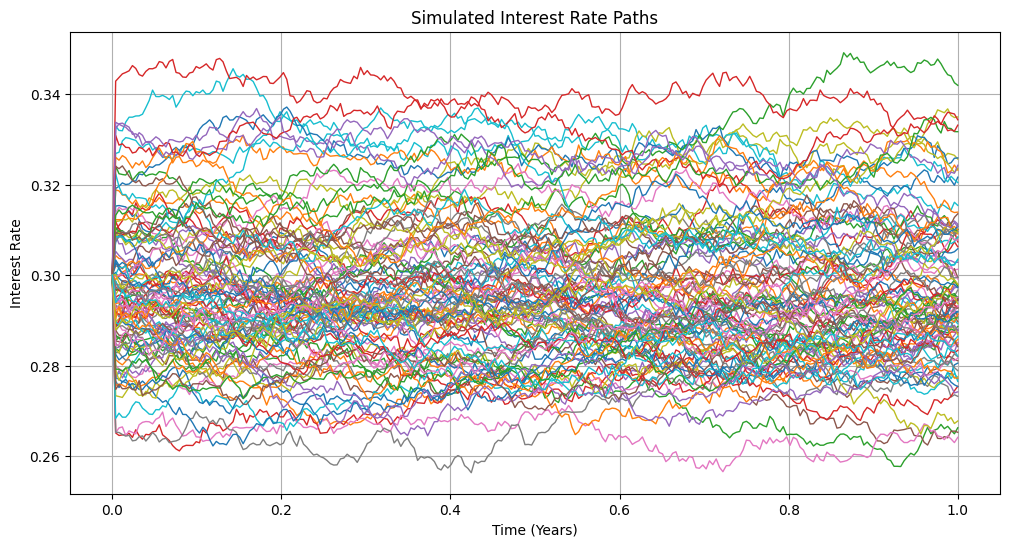

Estimated Average Bond Price: 0.7411
Standard Deviation of Bond Prices: 0.0100


In [52]:
# Define the model parameters
kappa = 0.5  # Mean reversion speed
mu_r = 0.3  # Long-term mean interest rate
sigma = 0.03  # Volatility of the interest rate
r = 100  # Number of successes (Negative Binomial)
p = 0.1  # Success probability (Negative Binomial)
mu = 0.0000  # Mean of the jump size distribution
gamma = 0.01  # Standard deviation of the jump size


# Initialize the ECIR model
model = ECIRModel(kappa, mu_r, sigma, r, p, mu, gamma)

# Setup Monte Carlo simulation parameters
start_rate = 0.3  # Initial interest rate
T = 1  # Total time in years
n = 252  # Number of time steps
num_sim = 100  # Number of simulations

# Create a Monte Carlo simulation instance
mc_simulator = MonteCarlo(model, start_rate, T, n, num_sim)

# Generate paths
paths = mc_simulator.paths()

# Plot the paths
plt.figure(figsize=(12, 6))
for path in paths:
    plt.plot(np.linspace(0, T, n+1), path, linewidth=1)
plt.title("Simulated Interest Rate Paths")
plt.xlabel("Time (Years)")
plt.ylabel("Interest Rate")
plt.grid(True)
plt.show()

# Calculate and display the estimated bond prices
avg_price, std_dev = mc_simulator.price_estimates()
print(f"Estimated Average Bond Price: {avg_price:.4f}")
print(f"Standard Deviation of Bond Prices: {std_dev:.4f}")


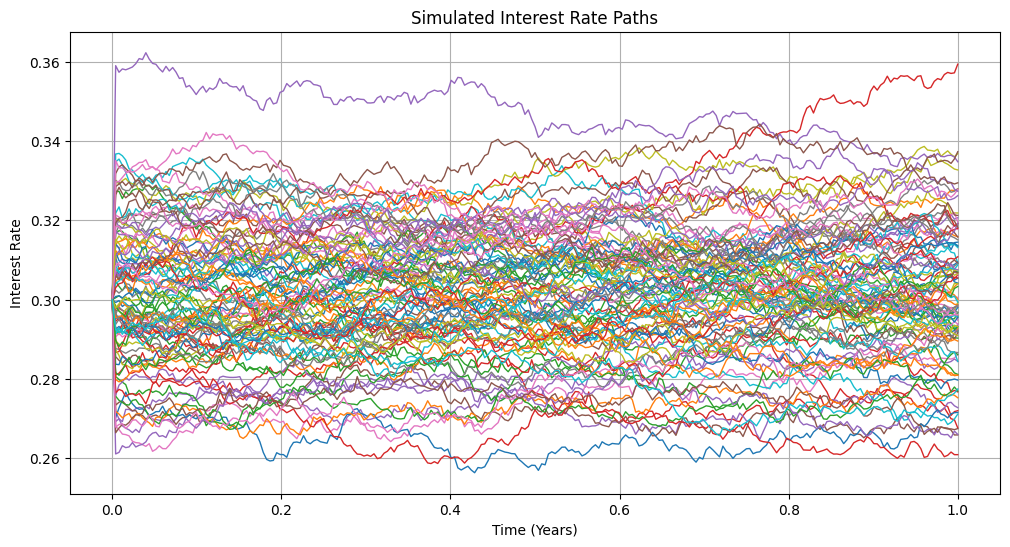

Estimated Average Bond Price: 0.7414
Standard Deviation of Bond Prices: 0.0103


In [53]:
# Define the model parameters
kappa = 0.5  # Mean reversion speed
mu_r = 0.3  # Long-term mean interest rate
sigma = 0.03  # Volatility of the interest rate
r = 100  # Number of successes (Negative Binomial)
p = 0.1  # Success probability (Negative Binomial)
mu = 0.0000  # Mean of the jump size distribution
gamma = 0.01  # Standard deviation of the jump size


model = BasicCIRModel(kappa, mu_r, sigma)

# Setup Monte Carlo simulation parameters
start_rate = 0.3  # Initial interest rate
T = 1  # Total time in years
n = 252  # Number of time steps
num_sim = 100  # Number of simulations

# Create a Monte Carlo simulation instance
mc_simulator = MonteCarlo(model, start_rate, T, n, num_sim)

# Generate paths
paths = mc_simulator.paths()

# Plot the paths
plt.figure(figsize=(12, 6))
for path in paths:
    plt.plot(np.linspace(0, T, n+1), path, linewidth=1)
plt.title("Simulated Interest Rate Paths")
plt.xlabel("Time (Years)")
plt.ylabel("Interest Rate")
plt.grid(True)
plt.show()

# Calculate and display the estimated bond prices
avg_price, std_dev = mc_simulator.price_estimates()
print(f"Estimated Average Bond Price: {avg_price:.4f}")
print(f"Standard Deviation of Bond Prices: {std_dev:.4f}")
